# COOKBOOK ESM

In [20]:
import pylab, numpy
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import interpolation
from scipy import interpolate
from astropy.io import fits
from scipy.interpolate import interp1d
from matplotlib import gridspec
#IMPORT Paste from Daniel Marsango author git HUB:
#import perfil  
#import doublespiral_image
#import gaus_sub
from calcu import disk_base,radial_profile,spiral_arm,gaussian,arcselip,calculations,calcul5,calcul10,calculento


### Define basic matrix parameters

In [21]:
######Parametros base da imagem #########
lambda0	=6562.8 #Comprimento de onda para modelagem, é possivel modelar todas as linhas em duplo-pico
ANGIi	=68    #angulo de inclinação do disco
broad	=1200   #parâmetro de turbulência da célula
shift	=0 #added manually bluefhift ou redfith do disco  
n	    =100  #numero de pontos na matriz ///define a quantidade de pontos por pixel
xi	    =2500 #eixo x da matrix
xf	    =2500 #eixo y da matriz


Creates emissivity matrices for each structure

In [22]:
## Disk and Structure Matrices ####

# Generate the base disk matrix
# disk_base(xi, xf, n, xi1, xi2)
disk = disk_base(-xi, xf, n, 500, 2500)

# Generate a broken radial emissivity disk matrix
# def radial_profile(xi, xf, n, q1, q2, xiq):
# q1 and q2 define the broken radial emissivity law:
# q1 < 0 (emissivity increases inward), q2 > 0 (emissivity decreases outward)
rad = radial_profile(-xi, xf, n, -2.5, 3.1, 945)

# Generate an emissivity matrix for a spiral arm
# spiral_arm(xi, xf, n, phi00, xisp, pp, xiww)
# Spiral arms are independent — several can be added at any position
arm = spiral_arm(-xi, xf, n, 38 + 120, 500, -45, 147)
arm2 = spiral_arm(-xi, xf, n, 77, 400, 20, 60)

# Generate a Gaussian emissivity matrix
# gaussian(xi, xf, n, mux, muy, sigmax, sigmay, angle_rot, angle_tran)
g = gaussian(-xi, xf, n, -1028, -73, 500, 500, 0, 90)
g2 = gaussian(-xi, xf, n, -988, -1730, 1000, 1000, 0, -1)

# Generate an emissivity matrix shaped as an elliptical arc with translation
# arcselip(xi, xf, n, a, b, theta0, scale, tangential_stretch,
#          radial_stretch, curvature, rotation_angle, trans, center_x, center_y)
arcelp = arcselip(-xi, xf, n,1, 2, np.radians(0),100, 2, 5.2, 0.004,np.radians(0), 0, 1000, 1000)



### Write any emissivity expression with the created matrices

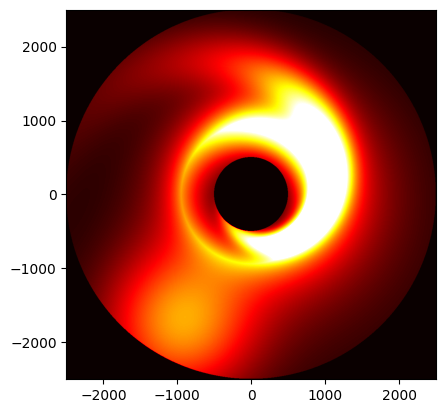

In [23]:
#EXAMPLE
disk_final = disk*(rad*(1+0.5*4.1*(arm)+4.8*arm2+0.2*g)+1.1*g2)
#disk_final=disk*2*arm+arm2
#or
#disk_final = disk*(rad*5*arm2+10*arm*g2)
#outra qualquer
plt.imshow(disk_final, extent=[-2500, 2500, -2500, 2500], vmin=0, vmax=2, cmap='hot')
#disk_final=np.rot90(disk_final,2)

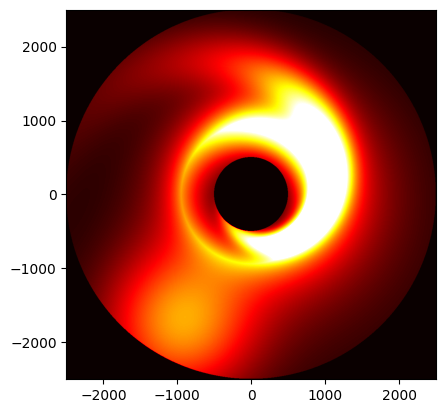

In [24]:
#disk_final=np.rot90(disk_final,2)
disk_final = disk*(rad*(1+0.5*4.1*(arm)+4.8*arm2+0.2*g)+1.1*g2)
plt.imshow(disk_final, extent=[-2500, 2500, -2500, 2500], vmin=0, vmax=2, cmap='hot')


### Calculate spectrum from map of emissivity

360


Conversão: 100%|██████████████████████| 7512/7512 [00:00<00:00, 45224.27ponto/s]


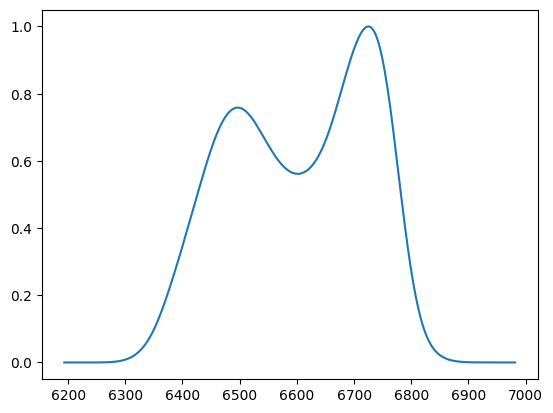

In [25]:

lam, flux,vel,points = calcul10(disk_final,lambda0,ANGIi,broad,xf,10)

# in calcul10(disk_final,lambda0,ANGIi,broad,xf,10) the value 10 in definition, use of diferential
#element of area, isto possibilita ajustar o espectro em poucos segundos. Elementos =1 podem demorar mais tempo 
#para calcular o perfil em duplo-pico.

plt.plot(lam,flux)


### Open Spectrum of our galaxy 

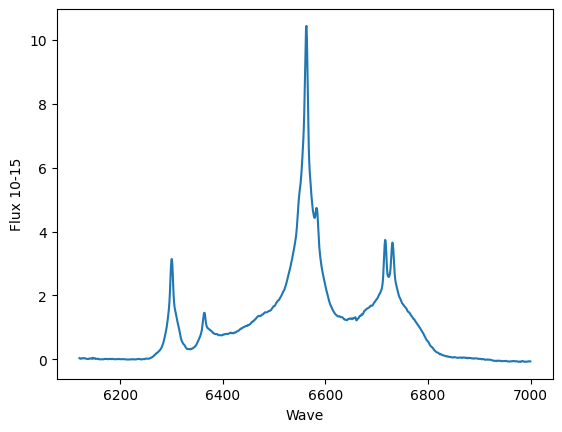

In [26]:
specobs='ha_comb_2012-10-15590ecAVG_Pictor_A_5900.fits'

# Open the FITS file
hdul = fits.open('ha_comb_2012-10-15590ecAVG_Pictor_A_5900.fits')

# Get the header information
header = hdul[0].header  # assuming the header is in the primary HDU


# Crie o vetor de onda
wave= np.linspace(header['CRVAL1'], header['CRVAL1'] + (header['NAXIS1']- 1) * header['CDELT1'], header['NAXIS1'])
fluxobs=hdul[0].data

plt.plot(wave,fluxobs)
plt.xlabel("Wave")
plt.ylabel("Flux 10-15")
plt.show()


# Close the FITS file



### Scaling observed Spectrum vs Spectrum from modeling

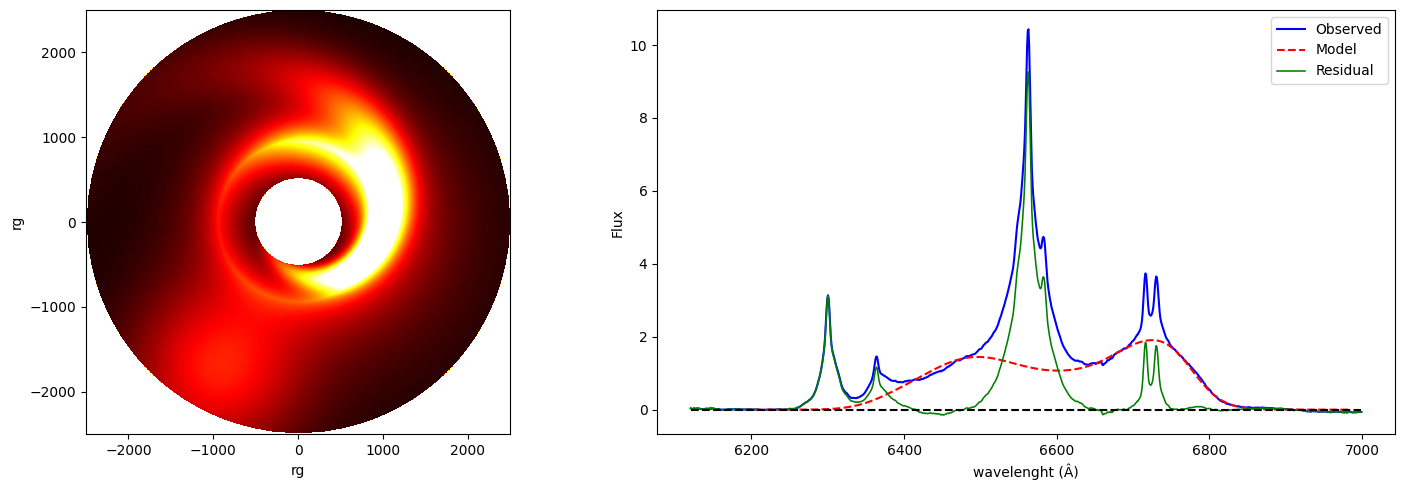

In [27]:
# Configurando o subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

##axs[0]
disk_final[disk_final == 0] = 500 # para melhorar a visualização, mas é opcional
# Plot da matriz de emissividade
axs[0].imshow(disk_final, extent=[-2500, 2500, -2500, 2500], vmin=0, vmax=3, cmap='hot')
axs[0].set_xlabel('rg')
axs[0].set_ylabel('rg')

##axs[1]

#plot dados observacionais
axs[1].plot(wave,fluxobs, 'b-', lw=1.5, label="Observed")
####Scalonando Fluxo
w1 = [6475, 6480]      
i1 = (wave >= w1[0]) & (wave <= w1[1])
i2=(lam >= w1[0]) & (lam <= w1[1])
# Calcular a média e normalizar
mean_fluxobs = np.mean(fluxobs[i1])
mean_flux = np.mean(flux[i2])
scale = mean_fluxobs/mean_flux
#print(scale)
model_wave = lam+shift
model_flux = flux*scale

#################Plots##########################################
#################################################################
axs[1].plot(model_wave, model_flux, "r--", label="Model")
#subtrair do original para verificar se reproduziu toda linha larga
interp_model_flux = interpolate.interp1d(model_wave, model_flux, kind='linear', fill_value='extrapolate')
# Interpolate model_flux based on wave
model_flux_interp = interp_model_flux(wave)
# Subtract model_flux_interp from flux
subtracted_flux = fluxobs - model_flux_interp
axs[1].plot(wave, subtracted_flux,'g-',lw=1.15, label="Residual")

#linha em zero
zero = numpy.zeros(numpy.size(wave))
axs[1].plot(wave, zero, 'k--')
axs[1].legend()
axs[1].set_xlabel('wavelenght (Â)')
axs[1].set_ylabel('Flux') 

plt.tight_layout()
plt.savefig(specobs[0:18]+".jpg")
plt.show()
#plt.close()




